In [1]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys
import os
# top_path = '..'
# if top_path not in sys.path:
#     sys.path.append(top_path)

coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
if coffea_path not in sys.path:
    sys.path.insert(0,coffea_path)
    
ak_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/local-packages/'

if ak_path not in sys.path:
    sys.path.insert(0,ak_path)
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util
from plotters.pltStyle import pltStyle
import mplhep as hep
pltStyle('hep')
# from collections.abc import Iterable
# %matplotlib notebook 
# %matplotlib notebook 

In [3]:
from helpers import sum_neg_pos_eta, rebin_hist, get_xsec_dict
from JetEtaBins import JetEtaBins, PtBins

from fileNames.available_datasets import dataset_dictionary

from uncertainty_helpers import get_output, sum_output, combine_flavors, get_spline, FlavorFractions, create_data_HerPy_differences
from uncertainty_plotters import plot_Efractions, plot_spectra, plot_ratio_comparisons_samples, plot_HerPydiff, plot_uncertainty

from uncertainty_helpers import get_ratio, read_data2, read_corrections, ptmin_global, ptmax_global
# from uncertainty_helpers import get_evaluator_limits, get_evaluator_limits_all_flav
from RatioPlotFitRes import RatioPlotFitRes, CorrectionEvaluator, get_additional_uncertainty_curves

# from common_binning import JERC_Constants

In [4]:
use_corrections = 'T' ### Which corrections to use for deriving the uncertainties 'T' for ttbar, 'J' for QCD
### If to include unmatched in calculating the uncertainties with seperate fits and
### include them in the flavor fraction plots.
### If False, unmatched are ignored
include_unmatched = False

eta_binning  = "Summer20Flavor"  ### HCalPart, CoarseCalo, CaloTowers, one_bin, Summer20Flavor;       
                         ### HCalPart: bin in HCal sectors, CaloTowers: the standard JERC binning,
                         ### CoarseCalo: like 'CaloTowers' but many bins united;

In [5]:
jeteta_bins = JetEtaBins(eta_binning, absolute=True)
pt_bins = PtBins("MC_truth")
eta_binning_str = '_'+eta_binning if eta_binning != "HCalPart" else ''

### Sum together all the different flavors and
### Get the splines of the flavor fractions

In [6]:
from scipy.interpolate import RegularGridInterpolator

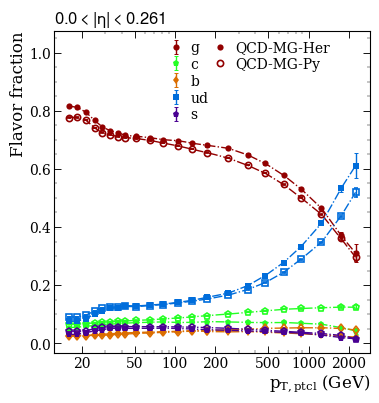

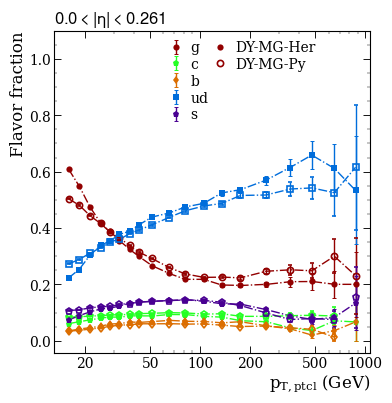

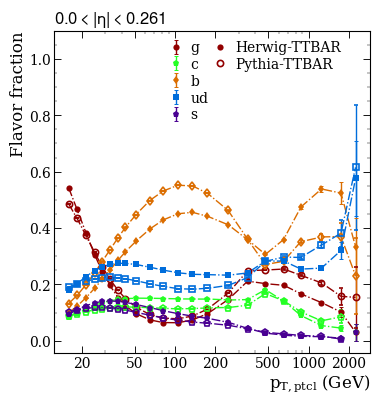

In [7]:
eta_idx = jeteta_bins.get_bin_idx(0)
flavors = ['g', 'c', 'b', 'ud', 's'] #, 'unmatched']
samples = ['QCD', 'DY', 'TTBAR']
Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
# samples = ['QCD', 'DY', 'TTBAR']
# Her_samples = ['_QCD-MG-Py_3rd_jet', '_DY-MG-Her', '_Herwig-TTBAR']
# Py_samples = ['_QCD-Py_3rd_jet', '_DY-MG-Py', '_Pythia-TTBAR'] #_sel_67ac6c3

qfrac_dict = {}
qfrac_var_dict = {}
qfrac_spline_dict = {}
# qfrac_spline_dict2 = {}
qfrac_spline_dict2D = {}
legend_labels = []
# include_unmatched = True
flavors = ['g', 'c', 'b', 'ud', 's' 'unmatched'] if include_unmatched==True else ['g', 'c', 'b', 'ud', 's']
saveplot = include_unmatched

for ii in range(len(samples)):
# for ii in range(1):
    sampHer = Her_samples[ii]
    sampPy = Py_samples[ii]
    samp = samples[ii]
    sample_plot = {}
    hists_rebinned_dict = {}
    
    for sample in [sampHer, sampPy]: #['QCD-MG-Her', 'QCD-MG-Py', 'QCD-Py_weights', 'QCD-Py']: #
        output = get_output(sample)
        file_dict, legend_label = get_xsec_dict(sample, dataset_dictionary)
        output = sum_output(output, sample, file_dict)
        hists = combine_flavors(output, sumeta=False, include_unmatched=False)
#         check_bins(hists[flavors[0]], jeteta_bins, pt_bins)
            
        hists_rebinned = {flav: rebin_hist(sum_neg_pos_eta(hists[flav]), 'jeteta', jeteta_bins.edges) for flav in hists.keys() }
        if include_unmatched==False: #recalculate the all
            hists_rebinned['all'] = sum([hists_rebinned[flav] for flav in flavors])
        hists_rebinned_dict[sample] = hists_rebinned
        hists_vals = {}
        for flav in hists_rebinned.keys():
            vals = hists_rebinned[flav].values().copy()
            vals[vals==0] = np.nan
            hists_vals[flav] = vals
        qfracs = {flav: hists_vals[flav]/hists_vals['all'] for flav in flavors}
#         qfracs_var = {flav: hists_rebinned[flav].variances()/hists_rebinned['all'].variances() for flav in flavors}
        qfrac_var = {'all': hists_rebinned['all'].variances()/hists_vals['all']**2}
        for flav in flavors:
            qfrac_var[flav] = qfracs[flav]**2*(hists_rebinned[flav].variances()/hists_vals[flav]**2 + qfrac_var['all']**2)
        Efrac_splines = {key: 
                         np.array([get_spline(qfracs[key][:,eta_idx], pt_bins) 
                          for eta_idx in range(jeteta_bins.nbins)
                         ])
                        for key in qfracs.keys()
                        }
        Efrac_2Dsplines = {key: RegularGridInterpolator((np.log10(pt_bins.centres), jeteta_bins.centres), qfracs[key], fill_value=None) 
                          for key in qfracs.keys()}
        
#         yval = qfracs['g'][:,0]

#         Efrac_fit_dict[sample] = Efrac_fits
        qfrac_dict[sample] = qfracs
        qfrac_var_dict[sample] = qfrac_var
        qfrac_spline_dict[sample] = FlavorFractions(Efrac_splines, eta_binning) #Efrac_splines #Efrac_2Dsplines
#         qfrac_spline_dict2[sample] = Efrac_splines
        
        qfrac_spline_dict2D[sample] = Efrac_2Dsplines
        sample_plot[sample] = [qfracs, qfrac_var, Efrac_splines, Efrac_2Dsplines]
        legend_labels.append(legend_label) if sample != 'QCD-Py_weights' else legend_labels.append(legend_label+', weights')

    plot_Efractions(sample_plot, eta_idx, jeteta_bins, pt_bins, saveplot=saveplot)
#     hists_rebinned_dict['_QCD-Py_weights'] = hist_mult(hists_rebinned_dict['_QCD-Py_weights'],10000)
#     plot_spectra(hists_rebinned_dict, legend_labels, 'all', eta_idx, jeteta_bins, pt_bins, saveplot=True, plotvspt=True)
#         correction_dict[sample] = {flav: read_corrections(sample, flav) for flav in flavors}


# Deriving the uncertainties

### Resum all the flavors for each sample

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p0to0p261


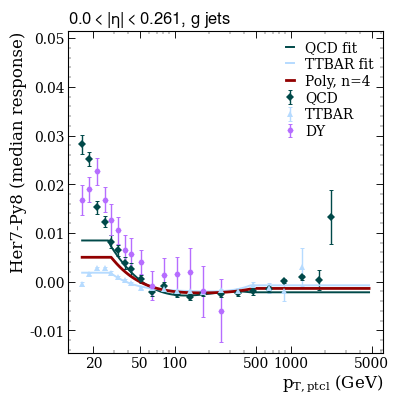

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p261to0p522


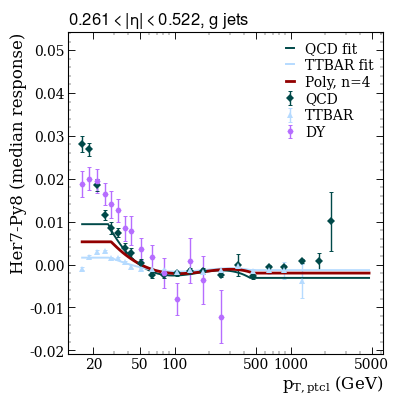

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p522to0p783


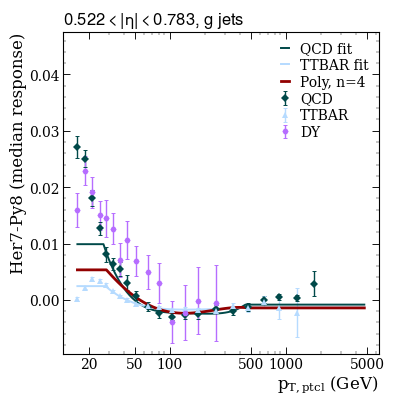

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta0p783to1p044


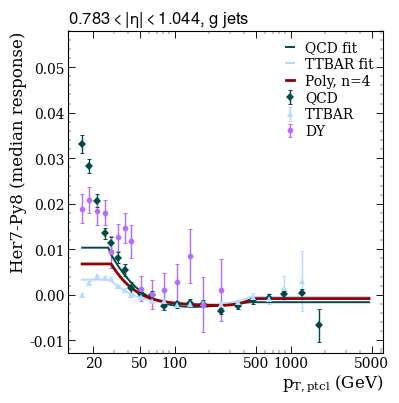

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta1p044to1p305


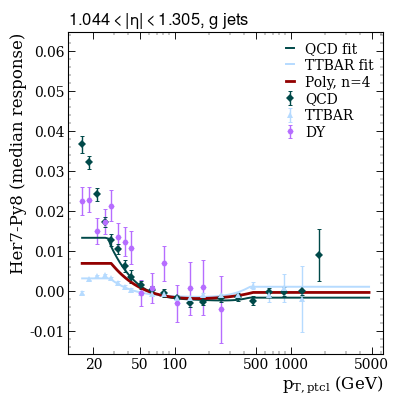

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta1p305to1p566


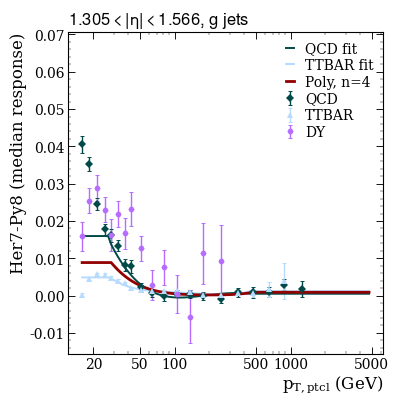

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta1p566to1p74


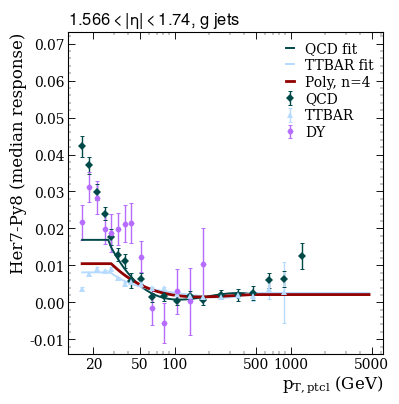

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta1p74to1p93


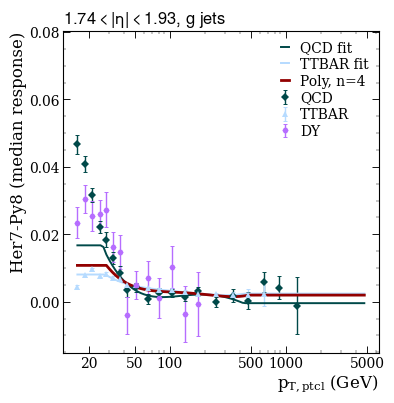

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta1p93to2p043


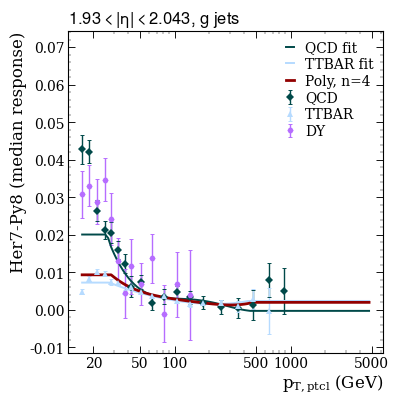

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta2p043to2p172


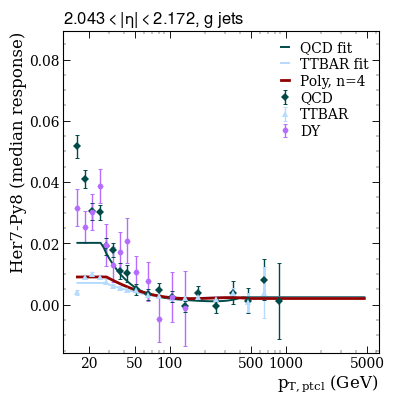

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta2p172to2p5


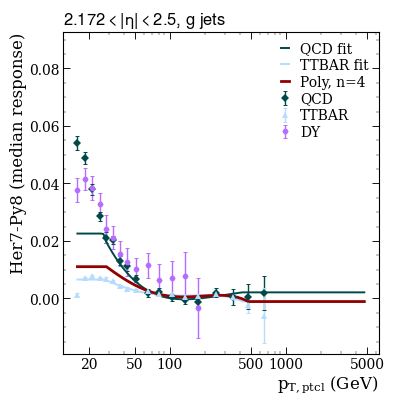

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta2p5to2p964


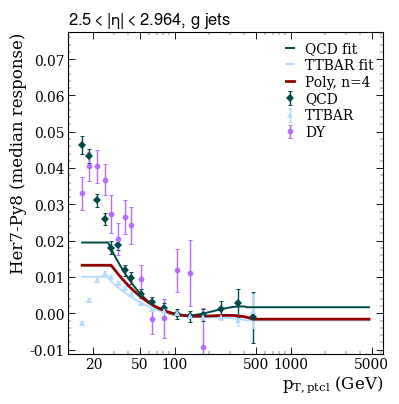

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_g_jets_eta2p964to5p191


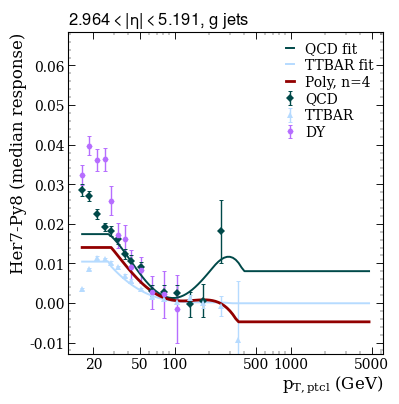

/tmp/anpotreb/ipykernel_10733/1418190908.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str )


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p0to0p261


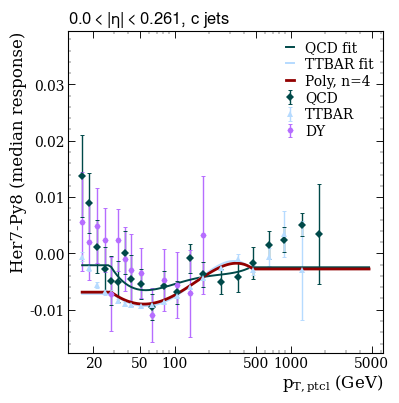

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p261to0p522


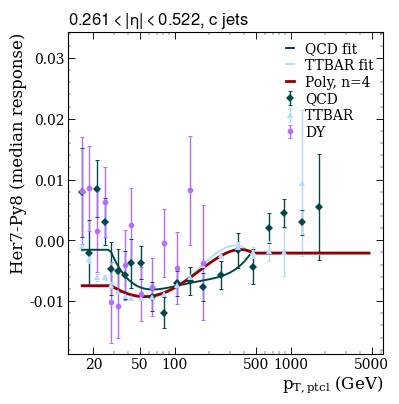

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p522to0p783


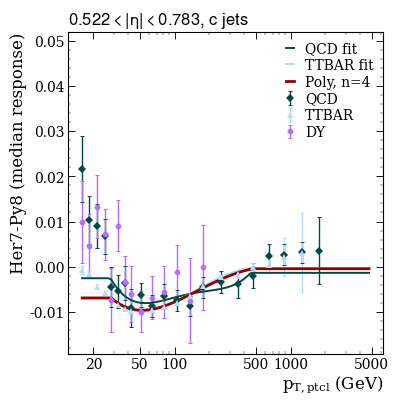

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta0p783to1p044


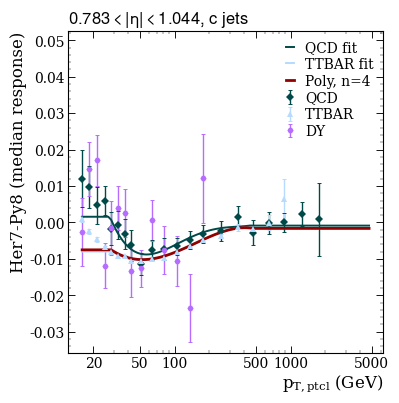

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta1p044to1p305


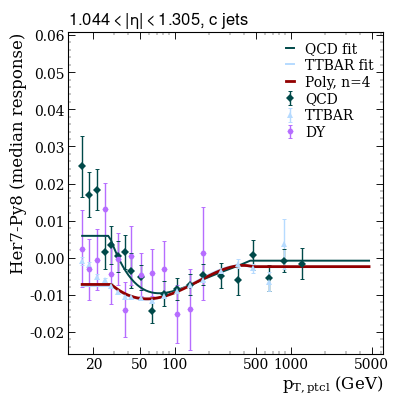

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta1p305to1p566


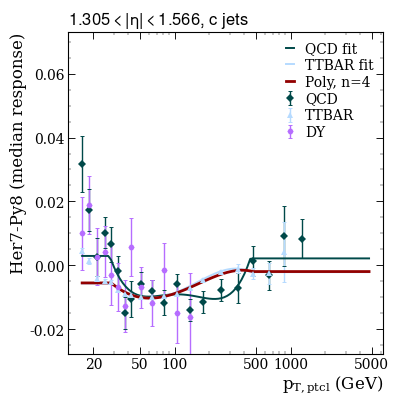

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta1p566to1p74


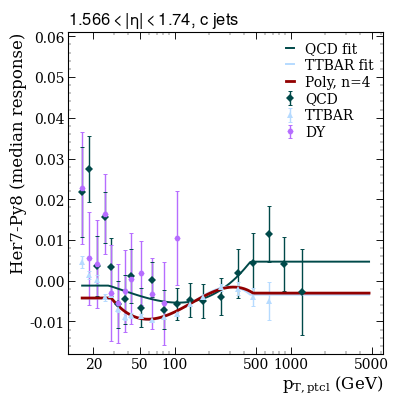

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta1p74to1p93


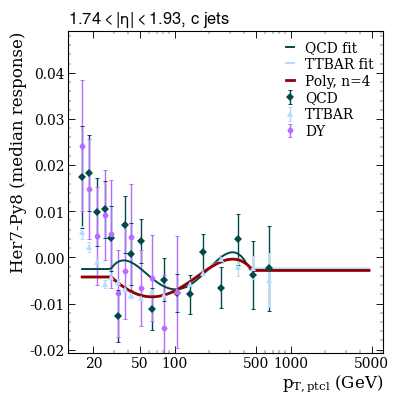

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta1p93to2p043


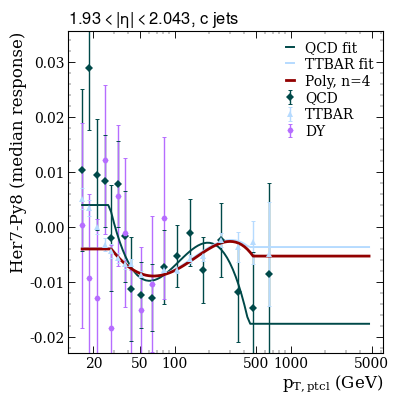

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta2p043to2p172


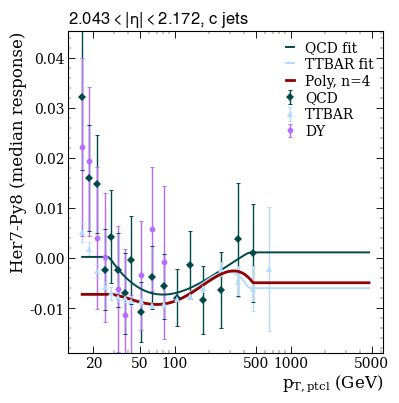

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta2p172to2p5


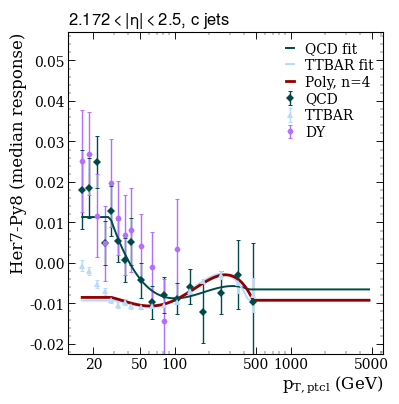

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta2p5to2p964


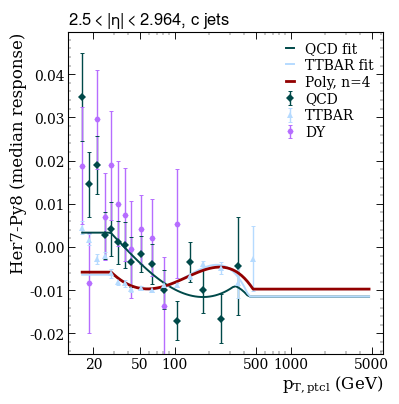

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_c_jets_eta2p964to5p191


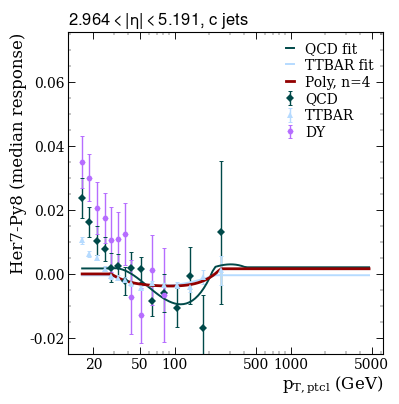

/tmp/anpotreb/ipykernel_10733/1418190908.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str )


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p0to0p261


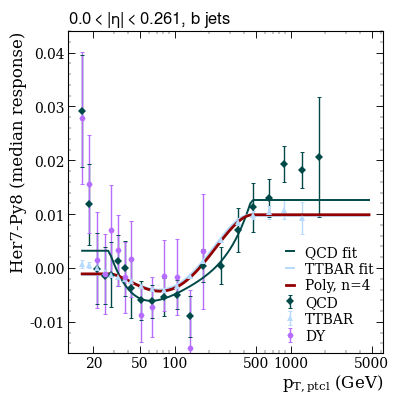

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p261to0p522


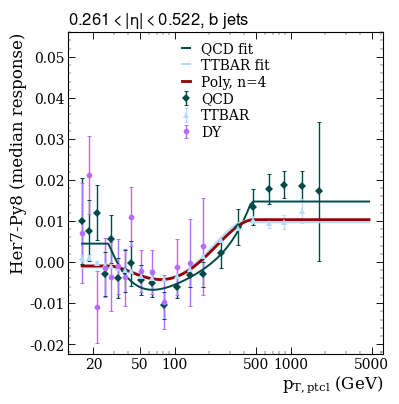

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p522to0p783


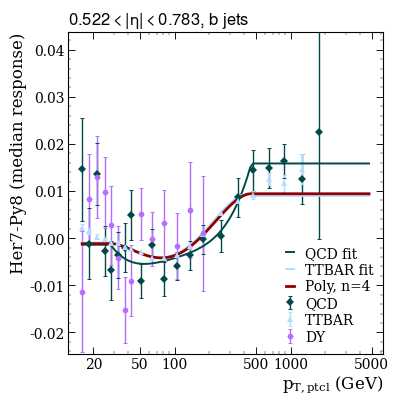

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta0p783to1p044


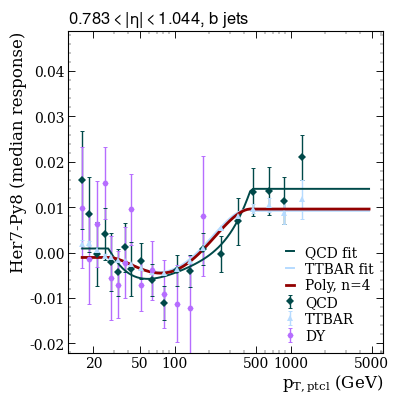

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta1p044to1p305


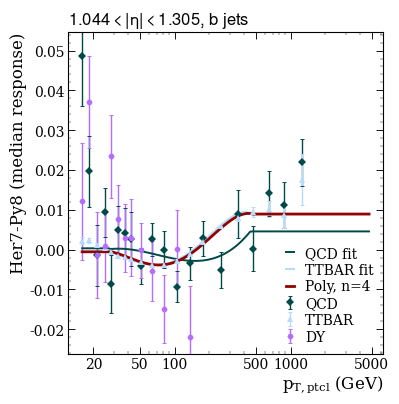

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta1p305to1p566


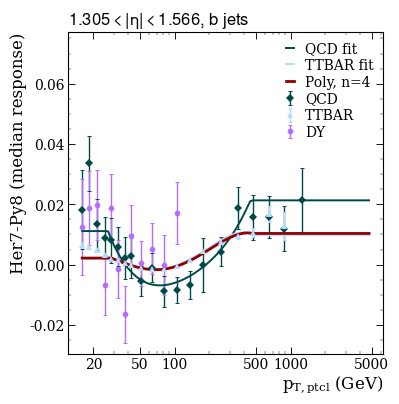

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta1p566to1p74


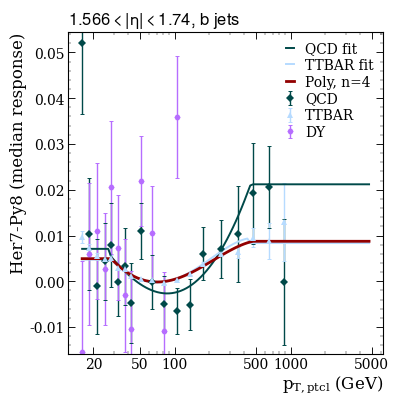

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta1p74to1p93


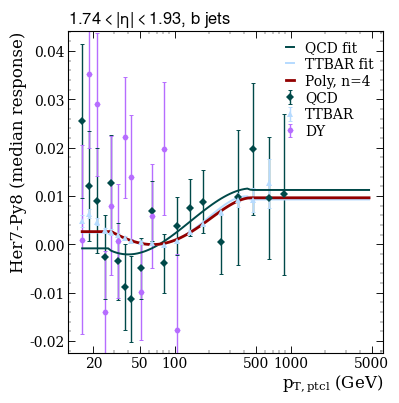

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta1p93to2p043


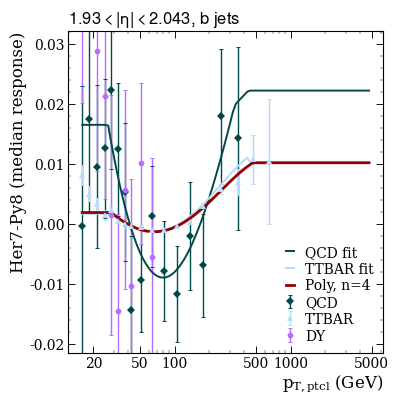

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta2p043to2p172


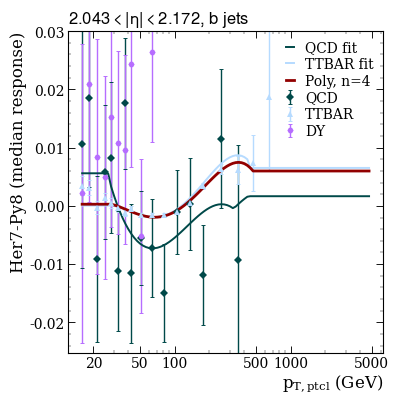

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta2p172to2p5


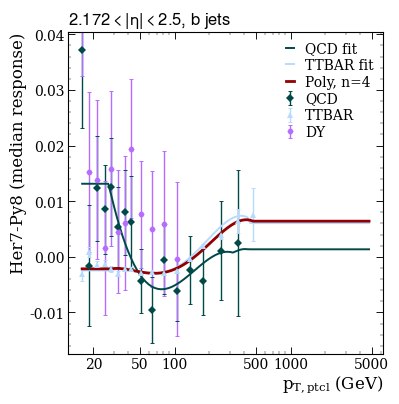

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta2p5to2p964


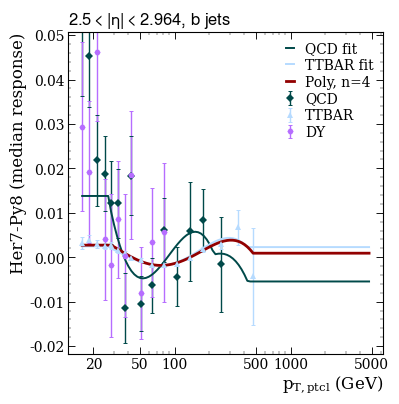

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_b_jets_eta2p964to5p191


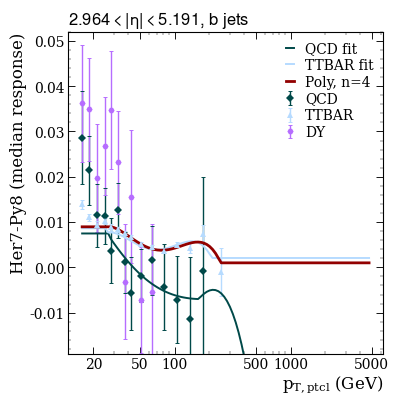

/tmp/anpotreb/ipykernel_10733/1418190908.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str )


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta0p0to0p261


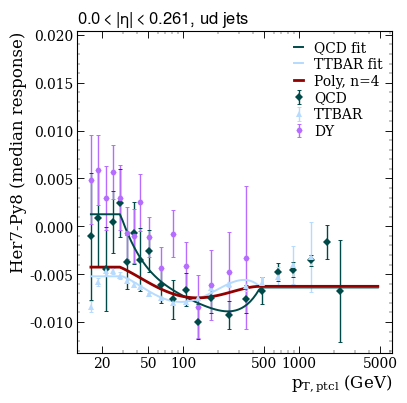

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta0p261to0p522


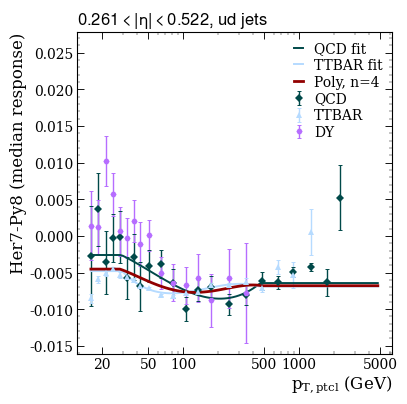

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta0p522to0p783


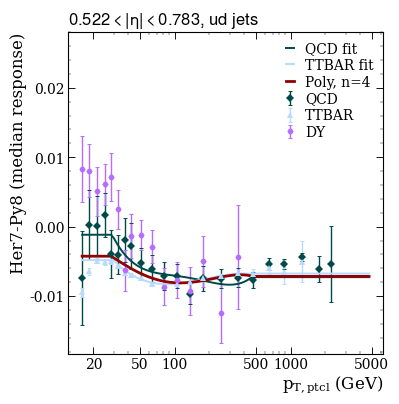

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta0p783to1p044


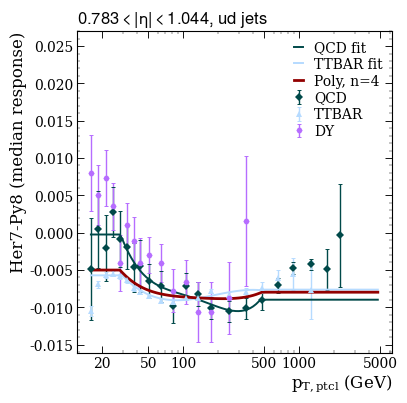

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta1p044to1p305


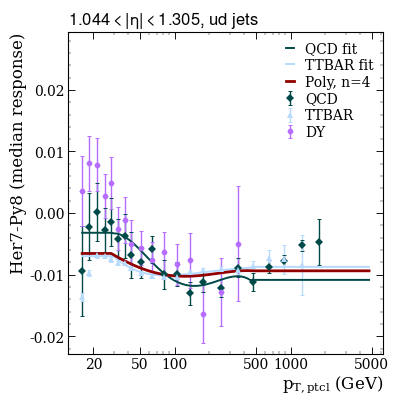

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta1p305to1p566


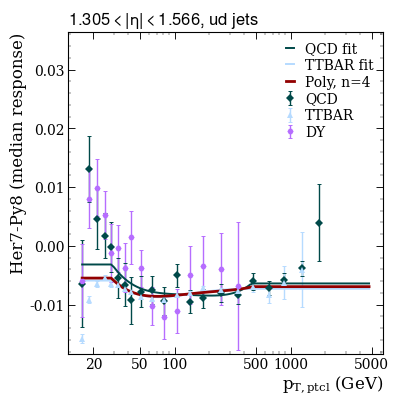

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta1p566to1p74


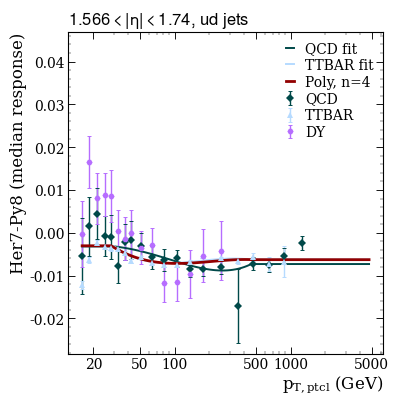

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta1p74to1p93


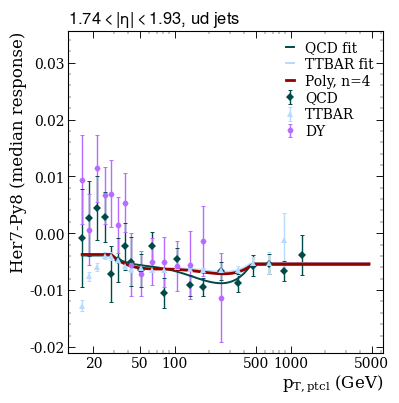

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta1p93to2p043


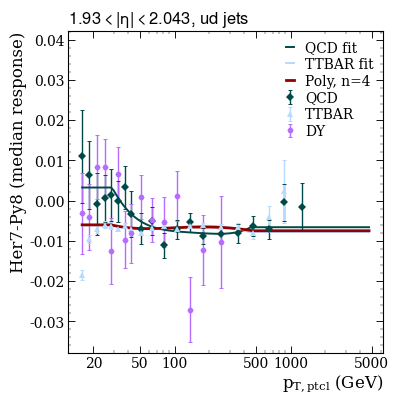

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta2p043to2p172


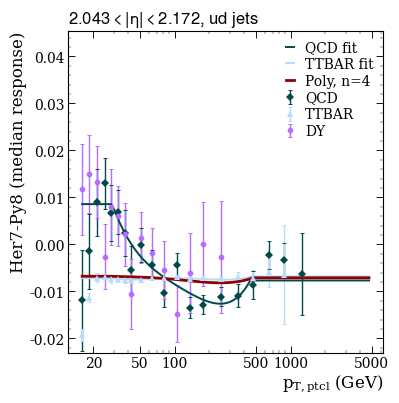

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta2p172to2p5


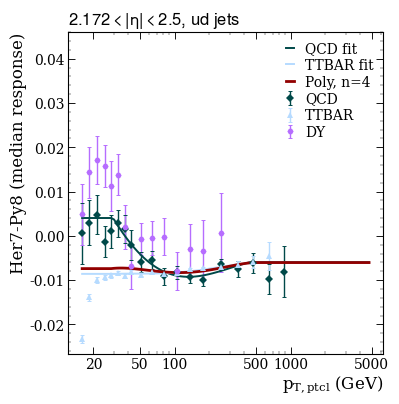

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta2p5to2p964


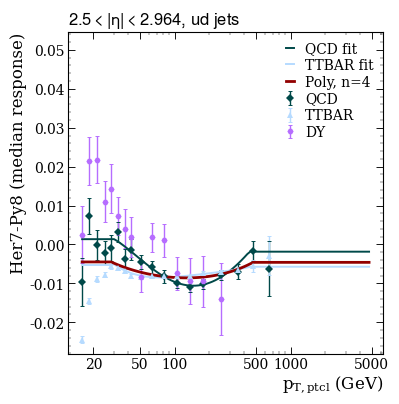

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_ud_jets_eta2p964to5p191


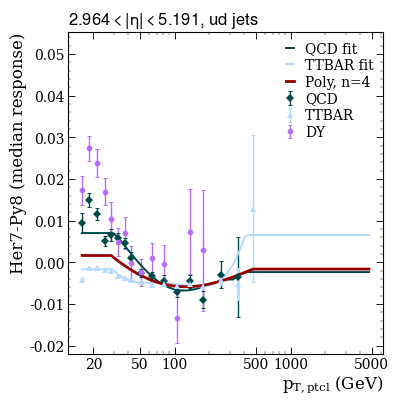

/tmp/anpotreb/ipykernel_10733/1418190908.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str )


Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta0p0to0p261


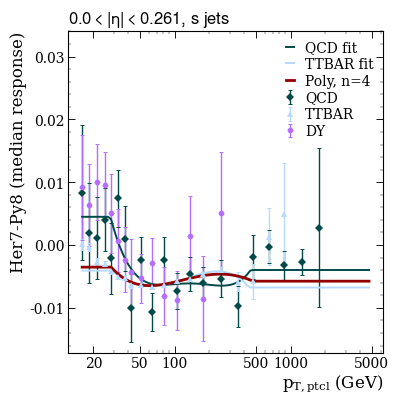

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta0p261to0p522


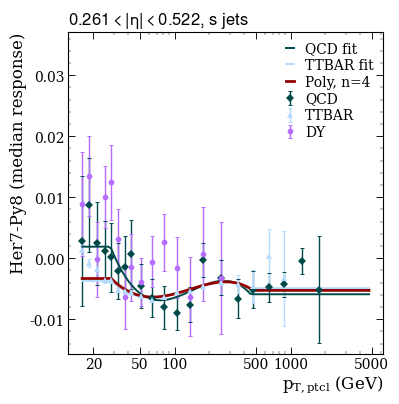

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta0p522to0p783


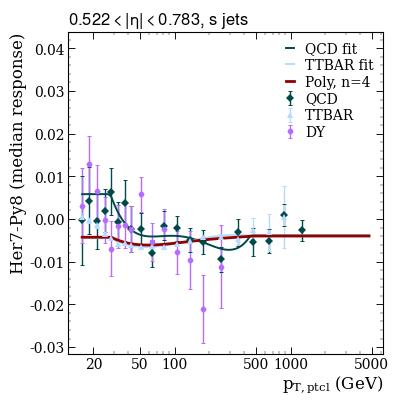

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta0p783to1p044


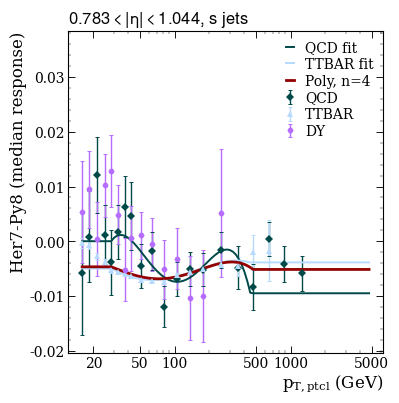

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta1p044to1p305


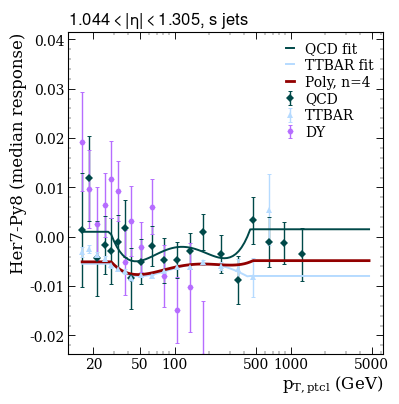

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta1p305to1p566


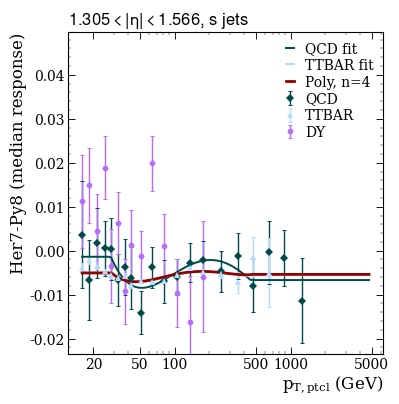

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta1p566to1p74


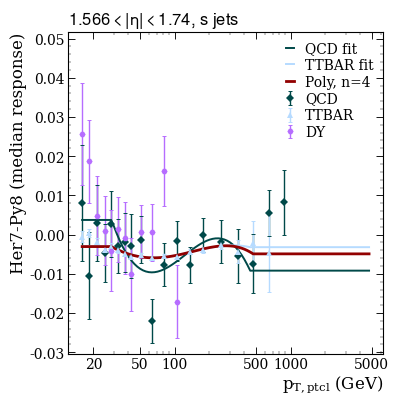

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta1p74to1p93


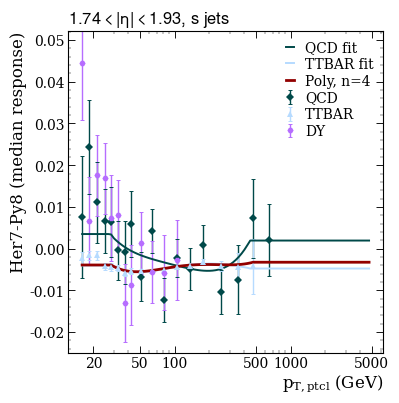

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta1p93to2p043


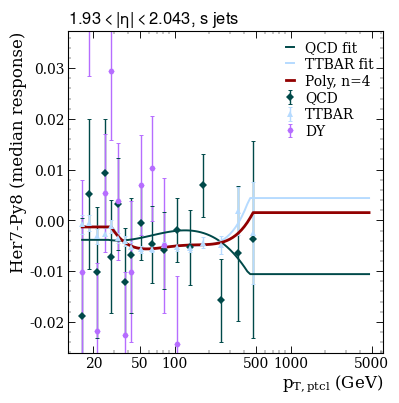

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta2p043to2p172


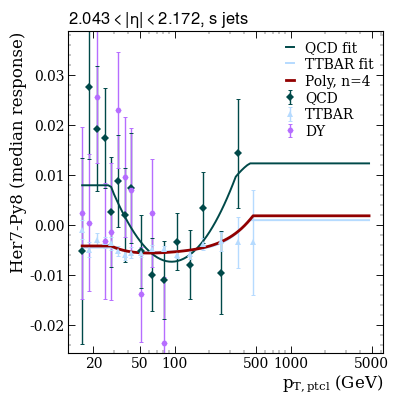

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta2p172to2p5


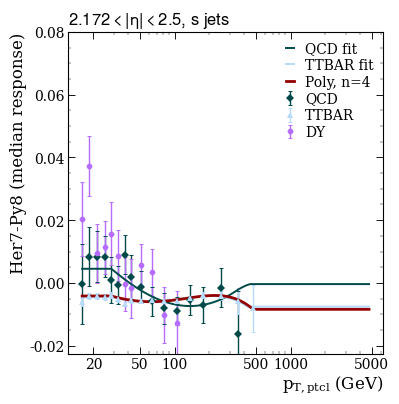

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta2p5to2p964


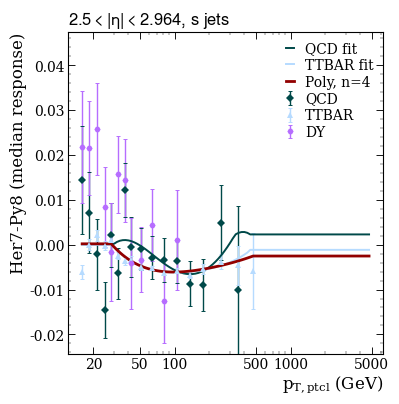

Saving plot with the name =  fig/uncertainty/Pythia_Herwig_all_samples_s_jets_eta2p964to5p191


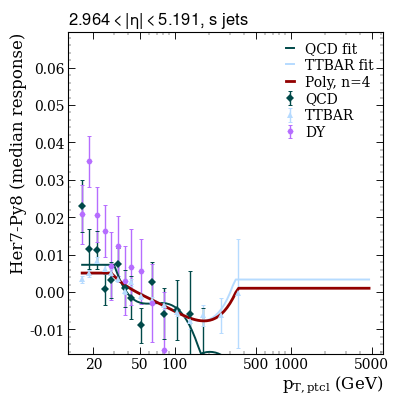

/tmp/anpotreb/ipykernel_10733/1418190908.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str )


In [10]:
ratio_fits = {}
Her_Py_ratio_fit_res = RatioPlotFitRes(binning=eta_binning, ptmin_global=ptmin_global, ptmax_global=ptmax_global)
for flav in flavors:
    fit_res_tmp = np.array([plot_ratio_comparisons_samples(flav, etaidx, jeteta_bins, pt_bins.centres, eta_binning_str ) 
                                for etaidx in range(jeteta_bins.nbins)]) #range(2)]) #
    Her_Py_ratio_fit_res.add_flavor(flav, fit_res_tmp)

To read the new fits

In [19]:
correction_txt_dir = 'Summer20UL18_V2_MC/'
correction_txt = 'Summer20UL18_V2_MC_L5Flavor_AK4PFchs'

### Read in the old Run1 flavor uncertainties to plot

In [20]:
from coffea.lookup_tools import extractor
# unc = ["* * Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor.junc.txt"]
unc = ["* * Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.junc.txt"]

ext = extractor()
ext.add_weight_sets(unc)
ext.finalize()
flav_evaluator = ext.make_evaluator()

lab_to_flav = {"DY" : "FlavorZJet",
               "QCD": "FlavorQCD",
               "GammaJet": "FlavorPhotonJet",
               "q":   "FlavorPureQuark",
               "c":   "FlavorPureCharm",
               "b":   "FlavorPureBottom",
               "g":   "FlavorPureGluon",
               }

# def get_uncertainties():
# uncertainties = {key:flav_evaluator[f'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_run2flavor_{lab_to_flav[key]}']
#                    for key in lab_to_flav}
uncertainties = {key:flav_evaluator[f'Summer19UL18_V5_MC_UncertaintySources_AK4PFchs_{lab_to_flav[key]}']
                   for key in lab_to_flav}

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta0p0to0p261.pdf / .png


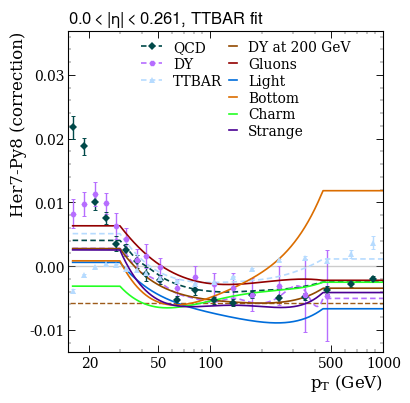

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_00eta0261_TTBAR_fit.pdf / .png


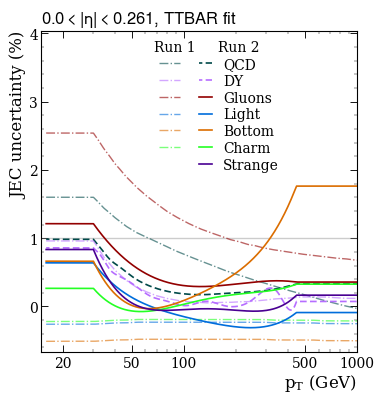

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta0p261to0p522.pdf / .png


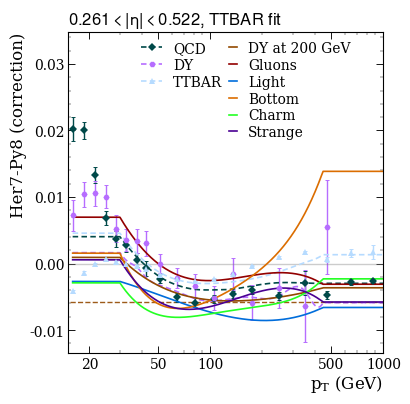

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_0261eta0522_TTBAR_fit.pdf / .png


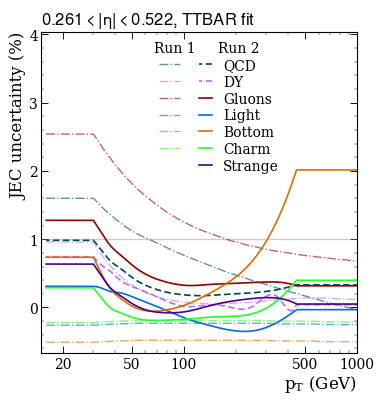

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta0p522to0p783.pdf / .png


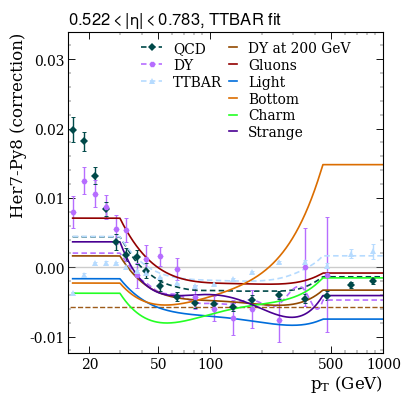

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_0522eta0783_TTBAR_fit.pdf / .png


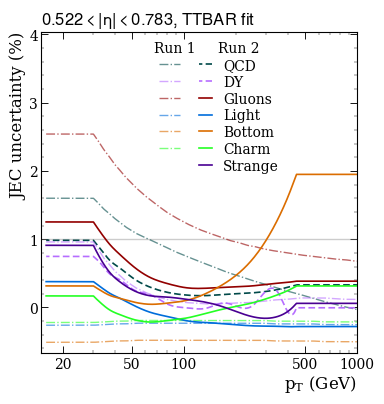

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta0p783to1p044.pdf / .png


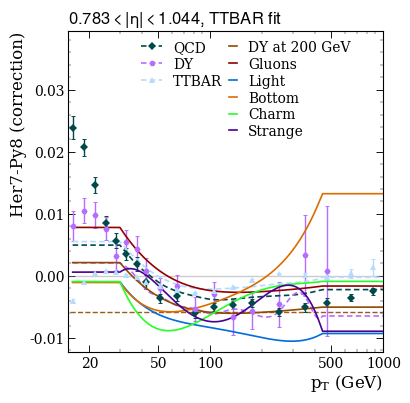

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_0783eta1044_TTBAR_fit.pdf / .png


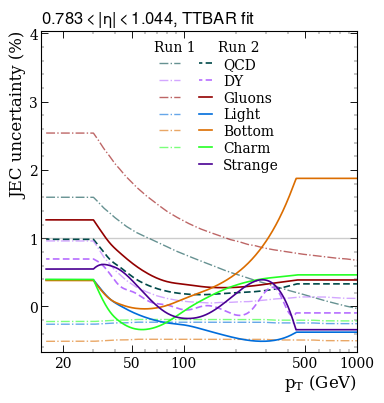

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta1p044to1p305.pdf / .png


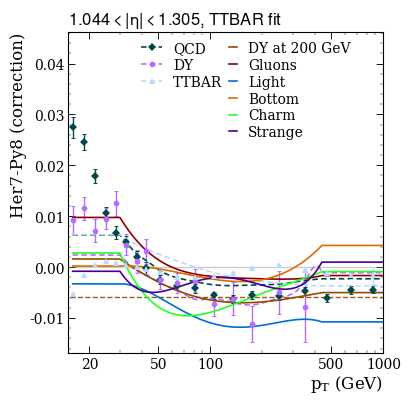

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_1044eta1305_TTBAR_fit.pdf / .png


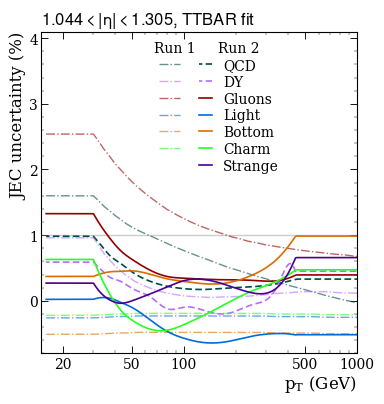

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta1p305to1p566.pdf / .png


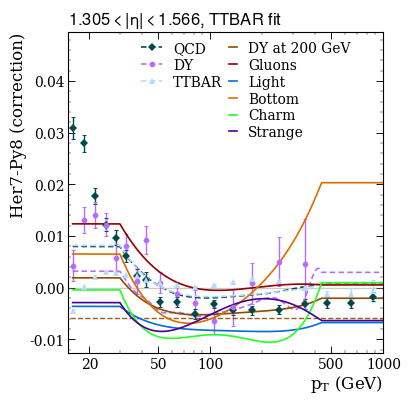

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_1305eta1566_TTBAR_fit.pdf / .png


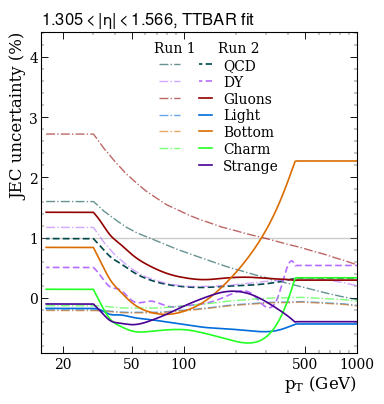

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta1p566to1p74.pdf / .png


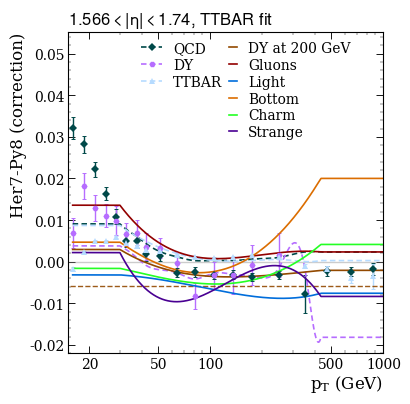

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_1566eta174_TTBAR_fit.pdf / .png


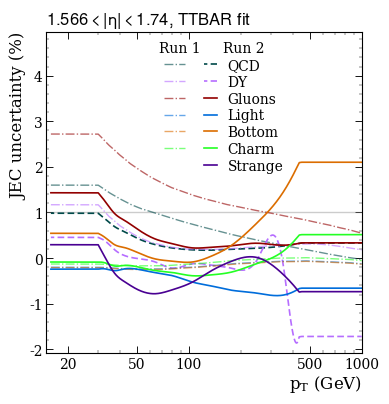

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta1p74to1p93.pdf / .png


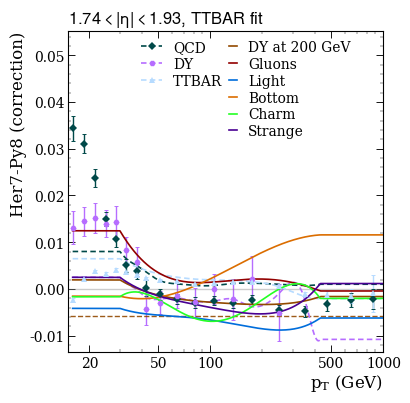

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_174eta193_TTBAR_fit.pdf / .png


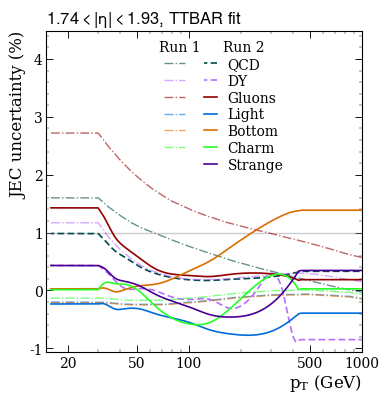

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta1p93to2p043.pdf / .png


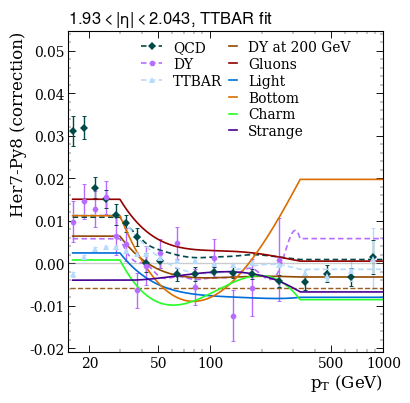

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_193eta2043_TTBAR_fit.pdf / .png


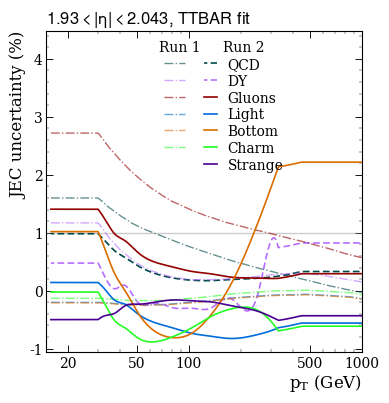

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta2p043to2p172.pdf / .png


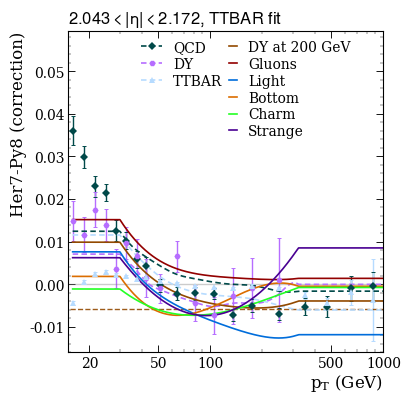

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_2043eta2172_TTBAR_fit.pdf / .png


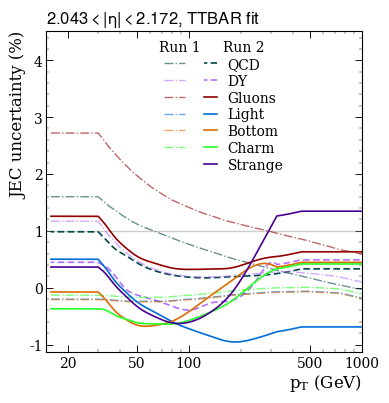

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta2p172to2p5.pdf / .png


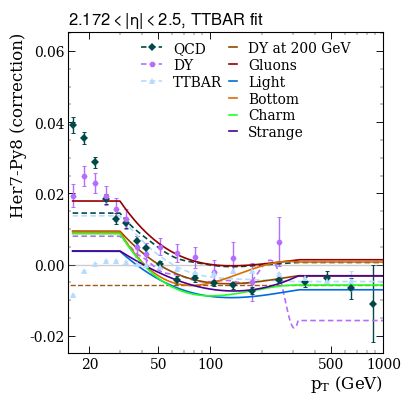

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_2172eta25_TTBAR_fit.pdf / .png


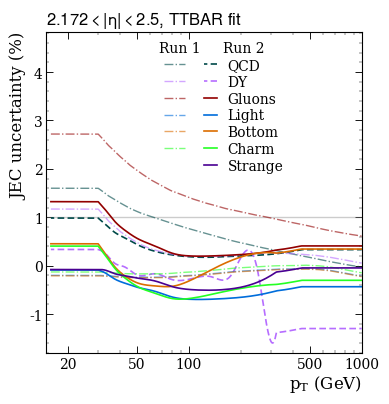

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta2p5to2p964.pdf / .png


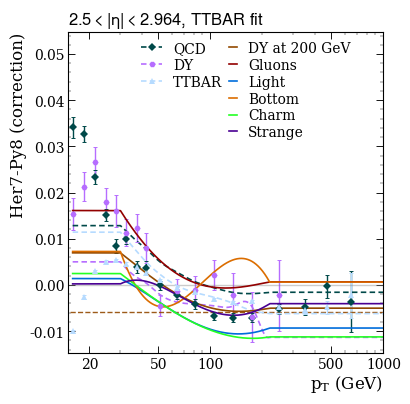

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_25eta2964_TTBAR_fit.pdf / .png


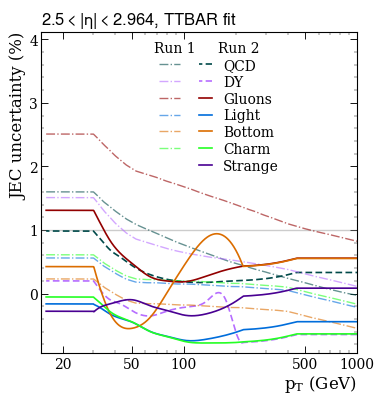

Saving plot with the name =  fig/uncertainty/Herwig_Pythia_difference__TTBAR_fiteta2p964to5p191.pdf / .png


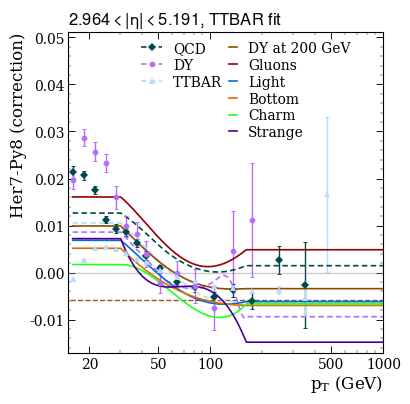

Saving plot with the name =  fig/uncertainty/JECuncertainty_vs_pt_eta_2964eta5191_TTBAR_fit.pdf / .png


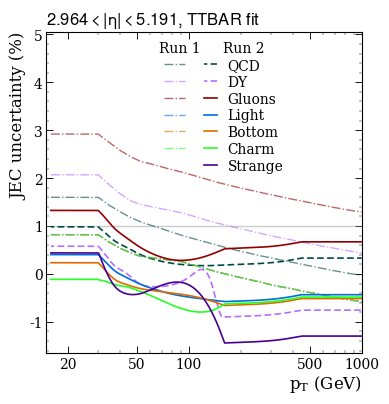

In [22]:
ptplot_vals = [] # [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals = jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False #True
plotvspt = True
use_corrections = 'T'
start_from_ratios = False

if start_from_ratios:
    pltstr2 = ', Combined fit'
else:
    if use_corrections=='T':
        pltstr2 = ', TTBAR fit'
    elif use_corrections=='J':
        pltstr2 = ', QCD fit'
    else:
        raise ValueError("wong correction type provided")

correction_evaluator = CorrectionEvaluator(binning=eta_binning,
                                        flavors=flavors,
                                        correction_txt_dir=correction_txt_dir,
                                        correction_txt=correction_txt,
                                        inverse=False,
                                        ptmin_global=ptmin_global,
                                        ptmax_global=ptmax_global,
                                        use_corrections='J',
                                       )
        
for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
#     print(f"plot val {plot_val}, plotvspt {plotvspt}")
    if plotvspt:
        ptvals = np.geomspace(pt_bins.centres.min(), pt_bins.centres.max(), 10000)
        idx = jeteta_bins.get_bin_idx(plot_val)
#         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
        etavals = np.ones(len(ptvals))*jeteta_bins.centres[idx]
        pt_idxs = range(pt_bins.nbins)
        eta_idxs = idx
    else:    
        etavals = np.linspace(jeteta_bins.centres.min(),jeteta_bins.centres.max(), 10000)
        idx = pt_bins.get_bin_idx(plot_val)
        ptvals = np.ones(len(etavals))*pt_bins.centres[idx]
#         pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = idx
        eta_idxs = range(jeteta_bins.nbins)
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
#     print('etaidx 1', idx)
#     pteta_grid = (np.log10(ptvals2), etavals)

    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins.edges[etaidx0] ##Used to  obtain the eta dependance from dijet
#     etavals02 = np.ones(len(ptvals2))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
#     pteta_grid0 = (np.log10(ptvals2), etavals02)

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
    Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]
#         HerPy_spline = get_ratio(resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid),
#               resum_to_mix(qfrac_spline_dict[sampPy], 'Py', etavals, ptvals, pteta_grid),
#               divideHerPy)
        difference_evaluator = Her_Py_ratio_fit_res if start_from_ratios else correction_evaluator
        HerPy_spline = difference_evaluator.resum_ratio_to_mix(
                                          etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy
                                        )
        corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse,
                                                              divideHerPy=divideHerPy, eta_binning_str=eta_binning_str)

        HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]


#     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)
    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      evaluator=difference_evaluator,
                                                                      qfrac_spline_dict=qfrac_spline_dict,
                                                                     divideHerPy=divideHerPy)
#     get_additional_uncertainty_curves_from_ratio(etavals, ptvals, etavals0)
    if plotvspt:
        plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx, jeteta_bins, pt_bins,
                       pltstr2)
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else f'$p_T$={str(pt_bins.centres[idx])} GeV'
                
        ptoretastr+=pltstr2
        plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, uncertainties, ptoretastr, plotvspt=plotvspt)

In [498]:
# ptplot_vals = [] # [16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = [2.8195-0.001] 
# etaplot_vals = [2.97] #jeteta_bins.centres #[16, 21.5, 32.5, 51, 105, 350, 650]


# # ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# plot_vals = list(etaplot_vals)+ptplot_vals
# plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

# inverse = False
# divideHerPy = False #True
# plotvspt = True
# use_corrections = 'J'
# start_from_ratios = False

# if start_from_ratios:
#     pltstr2 = ', Combined fit'
# else:
#     if use_corrections=='T':
#         pltstr2 = ', TTBAR fit'
#     elif use_corrections=='J':
#         pltstr2 = ', QCD fit'
#     else:
#         raise ValueError("wong correction type provided")

# def get_evaluator(sample='Her', flavor='b'):
#     return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

# for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
# #     print(f"plot val {plot_val}, plotvspt {plotvspt}")
#     if plotvspt:
#         ptvals = np.geomspace(pt_bins.centres.min(), pt_bins.centres.max(), 10000)
#         idx = jeteta_bins.get_bin_idx(plot_val)
# #         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
#         etavals = np.ones(len(ptvals))*jeteta_bins.centres[idx]
#         pt_idxs = range(pt_bins.nbins)
#         eta_idxs = idx
#     else:    
#         etavals = np.linspace(jeteta_bins.centres.min(),jeteta_bins.centres.max(), 100)
#         idx = pt_bins.get_bin_idx(plot_val)
#         ptvals = np.ones(len(etavals))*pt_bins.centres[idx]
# #         pteta_grid = (np.log10(ptvals), etavals)
#         pt_idxs = idx
#         eta_idxs = range(jeteta_bins.nbins)
#     ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)
# #     print('etaidx 1', idx)
# #     pteta_grid = (np.log10(ptvals2), etavals)

#     etaidx0=0 
#     etavals0 = np.ones(len(ptvals2))*jeteta_bins.edges[etaidx0] ##Used to  obtain the eta dependance from dijet
# #     etavals02 = np.ones(len(ptvals2))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
# #     pteta_grid0 = (np.log10(ptvals2), etavals02)

#     samples = ['QCD', 'DY', 'TTBAR']
#     Her_samples = ['QCD-MG-Her', 'DY-MG-Her', 'Herwig-TTBAR']
#     Py_samples = ['QCD-MG-Py', 'DY-MG-Py', 'Pythia-TTBAR']
#     HerPy_differences = {}
#     for ii in range(len(samples)):  
#         sampHer = Her_samples[ii]
#         sampPy = Py_samples[ii]
#         samp = samples[ii]
# #         HerPy_spline = get_ratio(resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid),
# #               resum_to_mix(qfrac_spline_dict[sampPy], 'Py', etavals, ptvals, pteta_grid),
# #               divideHerPy)
#         HerPy_spline = resum_ratio_to_mix(etavals, ptvals,
#                                           qfrac_spline_dict[sampHer],
#                                           qfrac_spline_dict[sampPy],
#                                           divideHerPy, start_from_ratios=start_from_ratios)
# #         HerPy_spline = resum_to_mix(etavals, ptvals,
# #                                                qfrac_spline_dict[sampHer], qfrac_spline_dict[sampPy])

# #         print()
#         corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

#         HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]


# #     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)
#     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
#                                                                       HerPy_differences['QCD'][0],
#                                                                       start_from_ratios=start_from_ratios)
# #     get_additional_uncertainty_curves_from_ratio(etavals, ptvals, etavals0)
#     if plotvspt:
#         plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx, jeteta_bins, pltstr2)
    
#     if not divideHerPy:
# #         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
#         ptoretastr = jeteta_bins.idx2plot_str(idx) if plotvspt else f'$p_T$={str(pt_bins.centres[idx])} GeV'
                
#         ptoretastr+=pltstr2
#         plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)

In [ ]:
jeteta_bins_unc = JetEtaBins("Uncert", absolute=True)
pt_bins_unc = PtBins("Uncert")

In [ ]:
# etavals
# ptvals

In [ ]:
# HerPy_spline

In [ ]:
ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
jeteta_bins_loc = jeteta_bins_unc
pt_bins_loc = pt_bins_unc

etaplot_vals = jeteta_bins_loc.centres #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False #True
plotvspt = True
use_corrections = 'J'
start_from_ratios = False

uncert_to_save = {flav: np.array([None]*pt_bins_loc.nbins) for flav in flavors}

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

for plot_val in plot_vals:
    ptvals = pt_bins_loc.centres
#         ptvals = np.geomspace(pt_bins_loc.centres.min(), pt_bins_loc.centres.max(), 1000)
    idx = jeteta_bins_loc.get_bin_idx(plot_val)
    etavals = np.ones(len(ptvals))*jeteta_bins_loc.centres[idx]
    pt_idxs = range(pt_bins_loc.nbins)
    eta_idxs = idx
    ptvals2= np.clip(ptvals, ptmin_global, ptmax_global)

    etaidx0=0 
    etavals0 = np.ones(len(ptvals2))*jeteta_bins_loc.edges[etaidx0] ##Used to  obtain the eta dependance from dijet

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
    Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']
    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]
        HerPy_spline = resum_ratio_to_mix(etavals, ptvals,
                                          qfrac_spline_dict[sampHer],
                                          qfrac_spline_dict[sampPy],
                                          divideHerPy, start_from_ratios=start_from_ratios)
#         corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

        HerPy_differences[samp] = [HerPy_spline, None, None]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
                                                                      HerPy_differences['QCD'][0],
                                                                      start_from_ratios=start_from_ratios)
    
    for flav in flavors:
        uncert_to_save[flav] = np.vstack([uncert_to_save[flav], additional_uncertainty_curves[flav+'100']-additional_uncertainty_curves['Rref']])
        assert False
        
    ptoretastr = jeteta_bins_loc.idx2plot_str(idx) if plotvspt else pt_bins_loc.centres[idx]
    plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)
#     if plotvspt:
#         plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx, jeteta_bins_loc)
    
#     if not divideHerPy:
#         ptoretastr = jeteta_bins_loc.idx2plot_str(idx) if plotvspt else pt_bins_loc.centres[idx]
#         plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)

for flav in flavors:
    uncert_to_save[flav] = uncert_to_save[flav][1:]

In [ ]:
# additional_uncertainty_curves['q100']


In [ ]:
# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = [2.8195-0.001] 
# etaplot_vals = etavals_unc_c #etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]
# etabins_c = etavals_unc_c


# # ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# # etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# plot_vals = list(etaplot_vals)+ptplot_vals
# plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

# inverse = False
# divideHerPy = False #True
# plotvspt = True
# use_corrections = 'T'

# def get_evaluator(sample='Her', flavor='b'):
#     return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

# for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
# #     print(f"plot val {plot_val}, plotvspt {plotvspt}")
#     if plotvspt:
#         ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
#         idx = np.searchsorted(etabins_c,plot_val)
# #         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
#         etavals = np.ones(len(ptvals))*etabins_c[idx]
#         pt_idxs = range(len(ptbins_c))
#         eta_idxs = idx
#     else:    
#         etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
#         idx = np.searchsorted(ptbins_c,plot_val)
#         ptvals = np.ones(len(etavals))*ptbins_c[idx]
#         pteta_grid = (np.log10(ptvals), etavals)
#         pt_idxs = idx
#         eta_idxs = range(len(etabins_abs)-1)

#     ptbins2 = np.clip(ptbins2, ptmin_global, ptmax_global)
#     pteta_grid = (np.log10(ptvals2), etavals)

#     etaidx0=0 
#     etavals0 = np.ones(len(ptvals2))*etabins_abs[etaidx0] ##Used to  obtain the eta dependance from dijet
#     etavals02 = np.ones(len(ptvals2))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
#     pteta_grid0 = (np.log10(ptvals2), etavals02)

#     samples = ['QCD', 'DY', 'TTBAR']
#     Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
#     Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']
#     HerPy_differences = {}
#     for ii in range(len(samples)):  
#         sampHer = Her_samples[ii]
#         sampPy = Py_samples[ii]
#         samp = samples[ii]
#         HerPy_spline = resum_ratio_to_mix(etavals, ptvals,
#                                           qfrac_spline_dict[sampHer],
#                                           qfrac_spline_dict[sampPy],
#                                           divideHerPy, start_from_ratios=True)
        
#         HerPy_differences[samp] = [HerPy_spline.T, None, None]
        
#     additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0,
#                                                                       HerPy_differences['QCD'][0],
#                                                                       start_from_ratios=True)

#     ptoretastr = f'[{np.round(etabins_uncert[idx],3)}, {np.round(etabins_uncert[idx+1],3)}]' if plotvspt else ptbins_c[idx]
#     plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, ptoretastr, plotvspt=plotvspt)
# #     plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, idx, plotvspt=plotvspt)

In [ ]:
new_uncertainties = {'Flavor'+key1: uncert_to_save[key2] for key1, key2 in zip(['PureGluon', 'PureCharm', 'PureBottom', 'PureQuark'], flavors) } # ['QCD', 'ZJet', 'PureGluon', 'PureQuark', 'PureCharm', 'PureBottom'] }
# unc_names = ['QCD', 'DY']

In [ ]:
# # jeteta_bins_unc.edges
# range(jeteta_bins_unc.nbins,1)
# range(jeteta_bins_unc.nbins)
# jeteta_bins_unc.nbins

In [ ]:
pt_bins_unc.nbins*3

In [ ]:
# [jeteta_bins_unc.edges[0], jeteta_bins_unc.edges[1]]
new_uncertainties = {}
for name, flav in zip(['PureGluon', 'PureCharm', 'PureBottom', 'PureQuark'], flavors):
    neg_etabins = [[-jeteta_bins_unc.edges[idx+1], -jeteta_bins_unc.edges[idx], pt_bins_unc.nbins*3] +
          list(np.column_stack((pt_bins_unc.centres, uncert_to_save[flav][idx], uncert_to_save[flav][idx])).reshape(-1))
    for idx in range(jeteta_bins_unc.nbins-1, -1, -1)]
    
    pos_etabins = [[jeteta_bins_unc.edges[idx], jeteta_bins_unc.edges[idx+1], pt_bins_unc.nbins*3] +
          list(np.column_stack((pt_bins_unc.centres, uncert_to_save[flav][idx], uncert_to_save[flav][idx])).reshape(-1))
    for idx in range(jeteta_bins_unc.nbins)]
    new_uncertainties ['Flavor'+name] = np.array(neg_etabins + pos_etabins)
    
    
    

In [ ]:
# for idx in range(jeteta_bins_unc.nbins-1, -1, -1):
#     print([-jeteta_bins_unc.edges[idx+1], -jeteta_bins_unc.edges[idx]])
# # new_uncertainties['FlavorPureGluon'][15][:10]
# # new_uncertainties['FlavorPureGluon'][-16][:10]

In [ ]:
def update_flavor_uncertainty_file(file_path, new_uncertainties):
    matched_section = False
    with open(file_path, 'r') as file:
        lines = file.readlines()

    output_lines = []
    i = 0
    while i < len(lines):
        line = lines[i]
        if line.startswith("["):
            section_title = line.strip()[1:-1]
            matched_section = section_title in new_uncertainties
            if matched_section:
                print('replacing secion:', section_title)
                output_lines.append(f'[{section_title}]\n')
                output_lines.append('{1 JetEta 1 JetPt "" Correction JECSource} \n')
                values = new_uncertainties[section_title]
                for value_row in values:
#                     output_lines.append(value_row+'\n')
                    output_lines.append(' '.join(map(str, np.round(value_row,4))) + '\n')

#                     output_lines.append('\n'.join(map(str, value_row)) + '\n')
                i += len(values)
            else:
                print('compying secion:', section_title)
                output_lines.append(line)
        elif not matched_section:
            output_lines.append(line)
        i += 1
    outfilename = file_path[:-4]+'_run2flavor.txt'
    print(f"Writing to a file '{outfilename}'")
    with open(outfilename, 'w') as file:
        file.writelines(output_lines)

In [ ]:
# np.array(neg_etabins)[:,:3]

In [ ]:
# new_uncertainties['FlavorPureBottom'][:,:3]

In [ ]:
update_flavor_uncertainty_file('Summer19UL18_V5_MC/Summer19UL18_V5_MC_UncertaintySources_AK4PFchs.txt', new_uncertainties)

In [ ]:
# (array([  16. ,   18.5,   21.5,   25. ,   28.5,   32.5,   37.5,   42.5,
#          51. ,   64.5,   81. ,  105. ,  135. ,  175. ,  250. ,  350. ,
#         475. ,  650. ,  875. , 1250. , 1750. , 2250. , 2750. , 3250. ,
#        3750. , 4250. , 4750. , 7500. ]), 2)

In [ ]:
sampHer = '_Herwig-TTBAR'
sampPy = '_QCD-MG-Py'

use_corrections = 'T'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

yval = resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid)

closure = read_data2('Median', sampPy, 'all')[:,0]
a = read_data2('Median', sampHer, 'all')[:,0] #/closure
delta_a = read_data2('MedianStd', sampHer, 'all')[:,0]
fig, ax = plt.subplots()
ax.plot(ptvals, yval, markersize=0, linewidth=1.2)
ax.plot(ptbins_c, a, linewidth=0)
ax.set_xscale('log')

# corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
# if divideHerPy:
#     corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[pt_idxs,eta_idxs]
# else:
#     corrstd_all = np.sqrt(delta_a**2+delta_b**2)[pt_idxs,eta_idxs]
# return [corr_all, corrstd_all]

In [ ]:
sampHer = '_QCD-MG-Her'
sampPy = '_QCD-MG-Py'

use_corrections = 'J'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

yval = resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid)

closure = read_data2('Median', sampPy, 'all')[:,0]
a = read_data2('Median', sampHer, 'all')[:,0]/closure
delta_a = read_data2('MedianStd', sampHer, 'all')[:,0]
fig, ax = plt.subplots()
ax.plot(ptvals, yval, markersize=0, linewidth=1.2)
ax.plot(ptbins_c, a, linewidth=0)
ax.set_xscale('log')

# corr_all = get_ratio(a, b, divideHerPy)[pt_idxs,eta_idxs]
# if divideHerPy:
#     corrstd_all = np.sqrt((delta_a/b)**2+(a/b**2*delta_b)**2)[pt_idxs,eta_idxs]
# else:
#     corrstd_all = np.sqrt(delta_a**2+delta_b**2)[pt_idxs,eta_idxs]
# return [corr_all, corrstd_all]

In [ ]:
ptplot_vals = [16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = [2.8195-0.001] 
etaplot_vals =  etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

# ptplot_vals = [] #[16, 21.5, 32.5, 51, 105, 350, 650]
# etaplot_vals = etabins_c #[16, 21.5, 32.5, 51, 105, 350, 650]

plot_vals = list(etaplot_vals)+ptplot_vals
plotvspt_ls = len(etaplot_vals)*[True]+len(ptplot_vals)*[False]

inverse = False
divideHerPy = False
plotvspt = False
use_corrections = 'J'

def get_evaluator(sample='Her', flavor='b'):
    return get_evaluator_pre(sample=sample, flavor=flavor , inverse=inverse, use_corrections=use_corrections)

for plot_val, plotvspt in zip(plot_vals, plotvspt_ls):
    if plotvspt:
        ptvals = np.geomspace(ptbins_c.min(), ptbins_c.max(), 1000)
        idx = np.searchsorted(etabins_c,plot_val)
#         etavals = np.ones(len(ptvals))*etabins_abs[etaidx]
        etavals = np.ones(len(ptvals))*etabins_c[idx]
        pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = range(len(ptbins_c))
        eta_idxs = idx
    else:    
        etavals = np.linspace(etabins_c.min(),etabins_c.max(), 100)
        idx = np.searchsorted(ptbins_c,plot_val)
        ptvals = np.ones(len(etavals))*ptbins_c[idx]
        pteta_grid = (np.log10(ptvals), etavals)
        pt_idxs = idx
        eta_idxs = range(len(etabins_abs))

    etaidx0=0 
    etavals0 = np.ones(len(ptvals))*etabins_abs[etaidx0] ##Used to  obtain the eta dependance from dijet
    etavals02 = np.ones(len(ptvals))*etabins_c[etaidx0] ##Used to  obtain the eta dependance from dijet
    pteta_grid0 = (np.log10(ptvals), etavals02)

    samples = ['QCD', 'DY', 'TTBAR']
    Her_samples = ['_QCD-MG-Her', '_DY-MG-Her', '_Herwig-TTBAR']
    Py_samples = ['_QCD-MG-Py', '_DY-MG-Py', '_Pythia-TTBAR']

    HerPy_differences = {}
    for ii in range(len(samples)):  
        sampHer = Her_samples[ii]
        sampPy = Py_samples[ii]
        samp = samples[ii]
        HerPy_spline = get_ratio(resum_to_mix(qfrac_spline_dict[sampHer], 'Her', etavals, ptvals, pteta_grid),
              resum_to_mix(qfrac_spline_dict[sampPy], 'Py', etavals, ptvals, pteta_grid),
              divideHerPy)

        corr_all, corrstd_all = create_data_HerPy_differences(sampHer, sampPy, pt_idxs, eta_idxs, inverse=inverse)

        HerPy_differences[samp] = [HerPy_spline, corr_all, corrstd_all]


    additional_uncertainty_curves = get_additional_uncertainty_curves(etavals, ptvals, etavals0, pteta_grid0)
    
    if plotvspt:
        plot_HerPydiff(ptvals, HerPy_differences, additional_uncertainty_curves, divideHerPy, idx)
    
    if not divideHerPy:
#         print("HerPy diff 1 = ", HerPy_differences['QCD'][0][:10]*100)
        plot_uncertainty(ptvals, etavals, HerPy_differences, additional_uncertainty_curves, idx, plotvspt=plotvspt)

In [ ]:
fig, ax = plt.subplots()
ax.plot(ptvals, get_ratio(
                                get_evaluator("Her", 'b')(etavals, ptvals),
                                get_evaluator("Py",  'b')(etavals, ptvals),
                                divideHerPy
                                 ) 
       )

ax.plot(ptvals, get_evaluator("Her", 'b')(etavals, ptvals)-1)
ax.plot(ptvals, get_evaluator("Py", 'b')(etavals, ptvals)-1)
ax.set_xscale('log')